In [3]:
import xarray as xr
import numpy as np
from tqdm import tqdm
from matplotlib import pylab as plt
import pickle

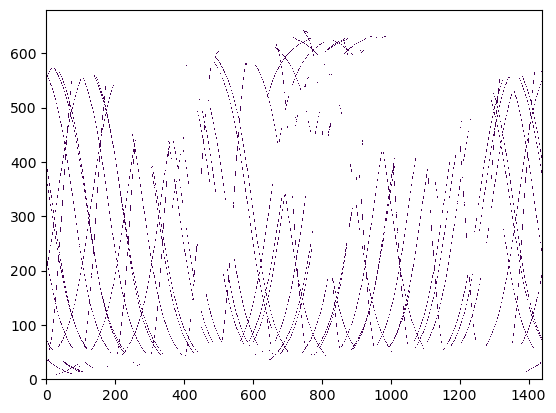

In [25]:
ifile="/Odyssey/public/glorys/obs_masks/global_obs_6sats_masks_2022.pickle"
with open(ifile, 'rb') as f:
    dic_pyo = pickle.load(f)
np.nanmean(dic_pyo[0])
plt.pcolormesh(dic_pyo[0])

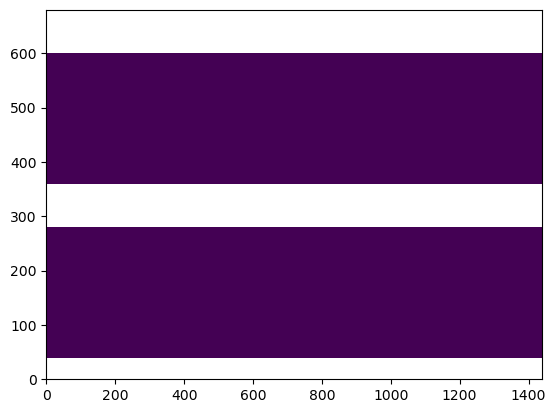

In [26]:
ifile="/Odyssey/private/t22picar/process_data/mask/mask_uv.pickle"
with open(ifile, 'rb') as f:
    dic_pyo = pickle.load(f)
np.nanmean(dic_pyo[0])
plt.pcolormesh(dic_pyo[0])

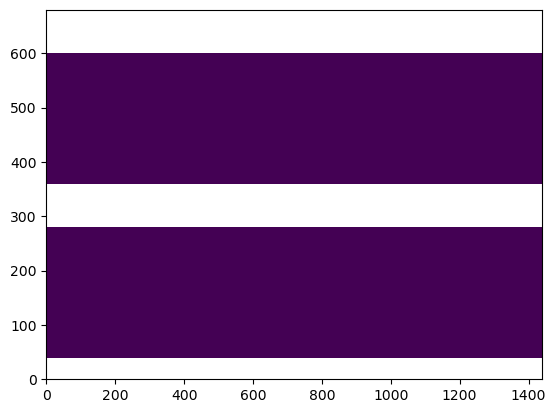

In [16]:
# Import reference grid 
map_4th = "/Odyssey/private/t22picar/data/glorys_15m/glorys_multivar_15m_2010-2018.nc"
map_4th = xr.open_dataset(map_4th).sel(time="2010-01-01")
lat = map_4th.lat.values
lon = map_4th.lon.values
lon2D, lat2D = np.meshgrid(lon, lat)
#mask = map_4th.zos.values

In [17]:
lat_mask = 10

#Mask close to the equator
mask = np.where((abs(lat2D)<lat_mask),np.nan,1)
#Mask high lat
mask = np.where((abs(lat2D)>70),np.nan,mask)
mask = np.where((abs(lat2D)<-70),np.nan,mask)

In [21]:
# Save the object to a file
with open('mask_uv.pickle', 'wb') as file:
    pickle.dump([mask], file)

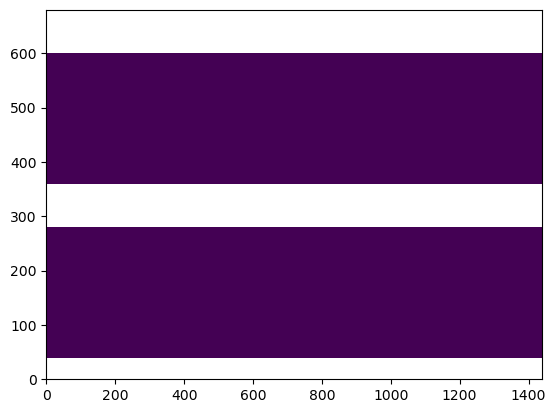

In [18]:
plt.pcolormesh(mask)

# CREATE .PICKLE MASK FILE

In [24]:
def get_list_masks(dataset_path):
    list_masks = []
    all_nadir_obs = xr.open_dataset(dataset_path)['ssh']
    print(all_nadir_obs.sizes)
    for nadir_obs in tqdm(all_nadir_obs[:]):
        nadir_obs = nadir_obs.to_numpy()
        nadir_obs[~np.isnan(nadir_obs)] = 1.0
        list_masks.append(nadir_obs)
    return list_masks

import pickle

def serialize_masks(path, mask_list):
    with open(path, 'wb') as handle:
        pickle.dump(mask_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
mask_list = get_list_masks(file_obs)

Frozen({'time': 364, 'lat': 680, 'lon': 1440})


  0%|          | 0/364 [00:00<?, ?it/s]

100%|██████████| 364/364 [00:15<00:00, 23.46it/s]


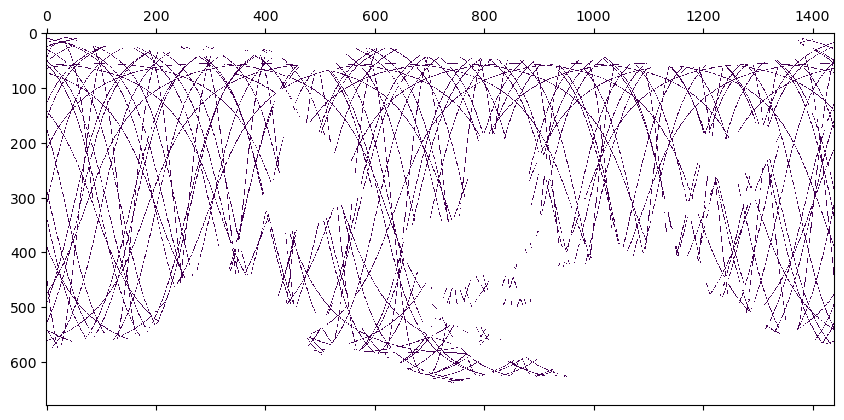

In [26]:
plt.matshow(mask_list[50]) #checking if masks look like the original satelites files

In [27]:
#output_mask_path = "/DATASET/GLORYS12/global_obs_6sats_masks_2022.pickle"
output_mask_path = "/Odyssey/private/t22picar/data/mask/global_obs_6sats_masks_2019.pickle"
serialize_masks(output_mask_path, mask_list)

## REGRID A DATASET (TO LOWER RESOLUTION)

In [3]:
def regrid_da(regrid_sizes, da: xr.DataArray):

        lat_space = np.linspace(start=da.lat.min(), stop=da.lat.max(), num=regrid_sizes[0])
        lon_space = np.linspace(start=da.lon.min(), stop=da.lon.max(), num=regrid_sizes[1])

        new_da = da.interp({"lat":lat_space, "lon":lon_space}, method="linear")

        return new_da

In [3]:
# LOAD IN CHUNKS BECAUSE TOO BIG FOR MEMORY
da = xr.open_dataset('/Odyssey/public/glorys/reanalysis/multivar/cmems_mod_glo_phy_my_0.083deg_P1D-m_multi-vars_180.00W-179.92E_80.00S-90.00N_0.49m_2010-01-01-2019-12-31.nc', chunks={'time': 50})
da = da.rename({'latitude':'lat', 'longitude':'lon'}).sel(depth=0.494025)
print(da.var)

new_sizes = [size // 3 for size in (2041, 4320)]
print('new sizes: {}'.format(new_sizes))

<bound method DatasetAggregations.var of <xarray.Dataset> Size: 773GB
Dimensions:  (lat: 2041, lon: 4320, time: 3652)
Coordinates:
    depth    float32 4B 0.494
  * lat      (lat) float32 8kB -80.0 -79.92 -79.83 -79.75 ... 89.83 89.92 90.0
  * lon      (lon) float32 17kB -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * time     (time) datetime64[ns] 29kB 2010-01-01 2010-01-02 ... 2019-12-31
Data variables:
    thetao   (time, lat, lon) float64 258GB dask.array<chunksize=(50, 2041, 4320), meta=np.ndarray>
    zos      (time, lat, lon) float64 258GB dask.array<chunksize=(50, 2041, 4320), meta=np.ndarray>
    mlotst   (time, lat, lon) float64 258GB dask.array<chunksize=(50, 2041, 4320), meta=np.ndarray>
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...           

In [ ]:
# can take 30/40 minutes to complete for big datasets
new_da = regrid_da(regrid_sizes=new_sizes, da=da)
new_da.var

/DATASET/envs/p24hasle/miniconda/envs/4dvarnet-starter/lib/python3.10/site-packages/xarray/core/indexing.py:1598: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


<bound method DatasetAggregations.var of <xarray.Dataset> Size: 86GB
Dimensions:  (time: 3652, lat: 680, lon: 1440)
Coordinates:
    depth    float32 4B 0.494
  * time     (time) datetime64[ns] 29kB 2010-01-01 2010-01-02 ... 2019-12-31
  * lat      (lat) float64 5kB -80.0 -79.75 -79.5 -79.25 ... 89.5 89.75 90.0
  * lon      (lon) float64 12kB -180.0 -179.7 -179.5 ... 179.4 179.7 179.9
Data variables:
    thetao   (time, lat, lon) float64 29GB dask.array<chunksize=(50, 680, 1440), meta=np.ndarray>
    zos      (time, lat, lon) float64 29GB dask.array<chunksize=(50, 680, 1440), meta=np.ndarray>
    mlotst   (time, lat, lon) float64 29GB dask.array<chunksize=(50, 680, 1440), meta=np.ndarray>
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                     

In [ ]:
#output_path = '/DATASET/GLORYS12/reanalysis/glorys12_2010_1019_4th.nc'
output_path = 'your_output_path'
new_da.to_netcdf(output_path)